# Tutorial PAMAP2 with mcfly

This turorial is intended to talk you through the functionalities of mcfly. As an example dataset we use the publicly available [PAMAP2 dataset](https://archive.ics.uci.edu/ml/datasets/PAMAP2+Physical+Activity+Monitoring). It contains time series data from movement sensors worn by nine individuals. The data is labelled with the activity types that these individuals did and the aim is to train and evaluate a *classifier*.

Before you can start, please make sure you installed all the dependencies of mcfly (listed in requirements.txt) and make sure your jupyter notebook has a python3 kernel.

## Import required Python modules

In [1]:
import sys
import os
import numpy as np
import pandas as pd
# mcfly
from mcfly import tutorial_pamap2, modelgen, find_architecture, storage
# Keras module is use for the deep learning
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam

Using Theano backend.


## Download data and pre-proces data

We have created a function for you to fetch and pre-proces the data. Please specify the 'directory_to_extract_to' in the code below and then execute the cell. This will download the data into the directory and create a subdirectory 'PAMAP2'. The output of the function is outputpath which indicates where the data was stored.

In [2]:
# Specify in which directory you want to store the data:
directory_to_extract_to = 'data'

In [3]:
# Name of the output directory with data
outputdir = 'output'

In [ ]:
# Specifcy which columns to use. You can leave this as it is 
columns_to_use = ['hand_acc_16g_x', 'hand_acc_16g_y', 'hand_acc_16g_z',
                 'ankle_acc_16g_x', 'ankle_acc_16g_y', 'ankle_acc_16g_z',
                 'chest_acc_16g_x', 'chest_acc_16g_y', 'chest_acc_16g_z']
exclude_activities = [9, 10, 11, 18, 19, 20, 0]
outputpath = tutorial_pamap2.fetch_and_preprocess(directory_to_extract_to,columns_to_use, 
                                                  exclude_activities=exclude_activities,
                                                 output_dir=outputdir)

Data previously downloaded and stored in data/PAMAP2/
Start pre-processing all 9 files...


## Load the pre-processed data

Load the preprocessed data as stored in Numpy-files. Please note that the data has already been split up in a training (training), validation (val), and test subsets.

In [ ]:
X_train, y_train_binary, X_val, y_val_binary, X_test, y_test_binary = tutorial_pamap2.load_data(outputpath)

## Generate models

First step is to create a model architecture. As we do not know what architecture is best for our data we will create a set of models to investigate which architecture is most suitable for our data and classification task. You will need to specificy how many models you want to create with argument 'number_of_models'. See for a full overview of the optional arguments the function documentation of modelgen.generate_models by running `modelgen.generate_models?`.

##### What number of models to select?
This number differs per dataset. More models will give better results but it will take longer to evaluate them. We recommend trying only 2 models to begin with. If you have enough time you can try a larger number of models.

In [ ]:
num_classes = y_train_binary.shape[1]
models = modelgen.generate_models(X_train.shape,
                                  number_of_classes=num_classes,
                                  number_of_models = 2, #10,
                                  model_type = 'DeepConvLSTM',
                                  cnn_max_layers=3,
                                  deepconvlstm_max_conv_layers=3,
                                  deepconvlstm_max_lstm_layers=2)

In [6]:
# Inspect models:
models_to_print = [0,1] #range(len(models))
for i, item in enumerate(models):
    if i in models_to_print:
        model, params, model_types = item
        print("-------------------------------------------------------------------------------------------------------")
        print("Model " + str(i))
        print(" ")
        print("Hyperparameters:")
        print(params)
        print(" ")
        print("Model description:")
        model.summary()
        print(" ")
        print("Model type:")
        print(model_types)
        print(" ")

-------------------------------------------------------------------------------------------------------
Model 0
 
Hyperparameters:
{'fc_hidden_nodes': 719, 'filters': array([45]), 'learning_rate': 0.00027027849218909665, 'regularization_rate': 0.00010906652699721753}
 
Model description:
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_1 (BatchNorma (None, 512, 9)        36          batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)  (None, 512, 45)       1260        batchnormalization_1[0][0]       
____________________________________________________________________________________________________
batchnormalization_2 (BatchNorma (None, 512, 45)       180         convolution1d_1[0][0]            
____

## Compare models
Now that the model architectures have been generated it is time to compare the models by training them in a subset of the training data and evaluating the models in the validation subset. This will help us to choose the best candidate model. Performance results are stored in a json file.

In [7]:
# Define directory where the results, e.g. json file, will be stored
resultpath = directory_to_extract_to + '/PAMAP2/PAMAP2_Dataset/results_tutorial/' 
if not os.path.exists(resultpath):
        os.makedirs(resultpath)

In [8]:
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                           X_val, y_val_binary,
                                                                           models,nr_epochs=5,
                                                                           subset_size=300,
                                                                           verbose=True,
                                                                           outputfile=resultpath+\
                                                                                  'modelcomparison.json')

Training model 0 CNN
Train on 300 samples, validate on 2007 samples
Epoch 1/5
300/300 [==============================] - 26s - loss: 1.6713 - acc: 0.6100 - val_loss: 3.8941 - val_acc: 0.0135
Epoch 2/5
300/300 [==============================] - 24s - loss: 1.1576 - acc: 0.8733 - val_loss: 2.1326 - val_acc: 0.3109
Epoch 3/5
300/300 [==============================] - 23s - loss: 1.0918 - acc: 0.8600 - val_loss: 1.8229 - val_acc: 0.5451
Epoch 4/5
300/300 [==============================] - 23s - loss: 0.9880 - acc: 0.8833 - val_loss: 1.7835 - val_acc: 0.5237
Epoch 5/5
300/300 [==============================] - 23s - loss: 0.8842 - acc: 0.9067 - val_loss: 1.7704 - val_acc: 0.6218
Training model 1 CNN
Train on 300 samples, validate on 2007 samples
Epoch 1/5
300/300 [==============================] - 102s - loss: 1.8357 - acc: 0.6100 - val_loss: 2.5372 - val_acc: 0.1510
Epoch 2/5
300/300 [==============================] - 96s - loss: 1.3577 - acc: 0.8200 - val_loss: 2.4965 - val_acc: 0.4723
Ep

The histories object produced by the previous step contains the history of classifier performance with every iteration of the training process. To ease inspecting this information we developed function plotTrainingProcess, which is demonstrated in the cell below.

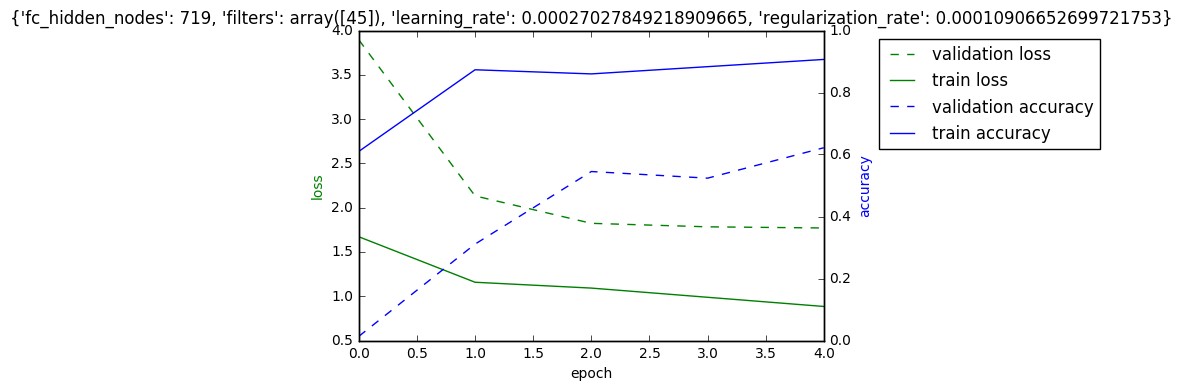

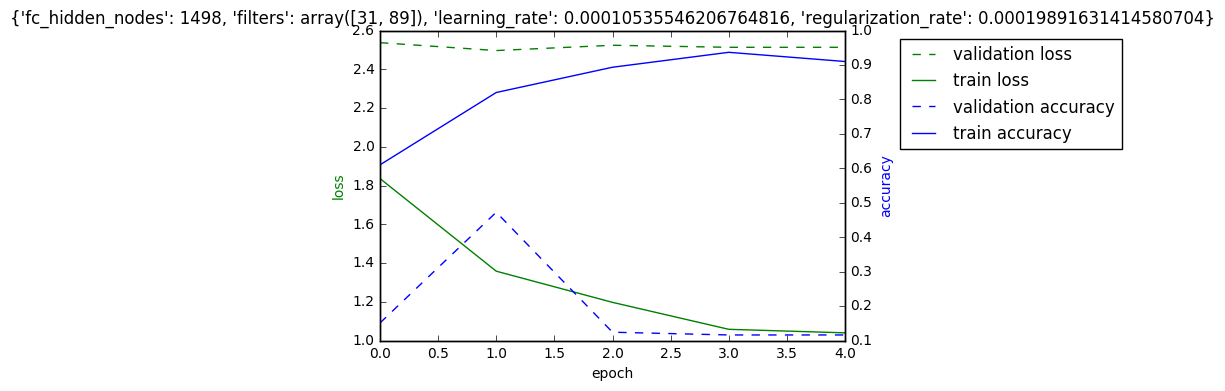

In [9]:
%matplotlib inline
for i in range(len(models)):
    name = str(models[i][1])
    find_architecture.plotTrainingProcess(histories[i], name)    

Another way of comparing model performance is by putting all the information in a pandas dataframe, which we can store in a csv file.

In [10]:
modelcomparisons = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                       'train_acc': [history.history['acc'][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_acc': [history.history['val_acc'][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
modelcomparisons.to_csv(resultpath +'modelcomparisons.csv')

modelcomparisons

,model,train_acc,train_loss,val_acc,val_loss
0,"{'fc_hidden_nodes': 719, 'filters': array([45]...",0.906667,0.884238,0.621824,1.770361
1,"{'fc_hidden_nodes': 1498, 'filters': array([31...",0.910000,1.039512,0.116094,2.513171


It is also possible to vizualize the performance of the various models using our vizualisation tool as explained in the mcfly repository README file: https://github.com/NLeSC/mcfly/blob/master/README.md

Check which model is the best

In [11]:
best_model_index = np.argmax(val_accuracies)
best_model, best_params, best_model_types = models[best_model_index]
print('Model type and parameters of the best model:')
print(best_model_types)
print(best_params)

Model type and parameters of the best model:
CNN
{'fc_hidden_nodes': 719, 'filters': array([45]), 'learning_rate': 0.00027027849218909665, 'regularization_rate': 0.00010906652699721753}


## Train the best model for real

Now that we have identified the best model architecture out of our random pool of models we can continue by training the model on the full training sample. For the purpose of speeding up the example we only train the full model on the first 1000 values. You will need to replace this by 'datasize = X_train.shape[0]' in a real world example.

In [12]:
#We make a copy of the model, to start training from fresh
best_model_copy = modelgen.generate_CNN_model(X_train.shape, num_classes, best_params['filters'], best_params['fc_hidden_nodes'],
                       best_params['learning_rate'], best_params['regularization_rate'])
nr_epochs = 5
#datasize = X_train.shape[0] #We're going to train the model on the complete data set
datasize = 1000 # subsample for the sake of this example
history = best_model_copy.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              nb_epoch=nr_epochs, validation_data=(X_val, y_val_binary))

Train on 1000 samples, validate on 2007 samples
Epoch 1/5
1000/1000 [==============================] - 42s - loss: 1.4285 - acc: 0.6870 - val_loss: 2.2137 - val_acc: 0.2337
Epoch 2/5
1000/1000 [==============================] - 40s - loss: 1.0247 - acc: 0.8660 - val_loss: 1.5811 - val_acc: 0.5954
Epoch 3/5
1000/1000 [==============================] - 39s - loss: 0.8436 - acc: 0.9210 - val_loss: 1.5724 - val_acc: 0.6956
Epoch 4/5
1000/1000 [==============================] - 38s - loss: 0.7390 - acc: 0.9510 - val_loss: 1.5802 - val_acc: 0.7190
Epoch 5/5
1000/1000 [==============================] - 40s - loss: 0.7278 - acc: 0.9560 - val_loss: 1.4361 - val_acc: 0.7240


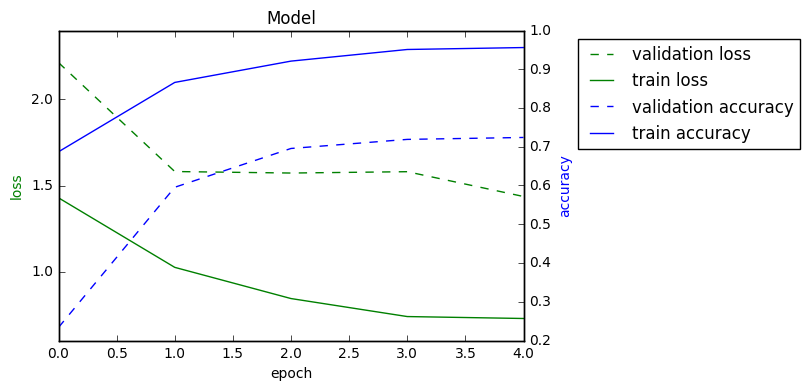

In [13]:
# Plot the training process:
find_architecture.plotTrainingProcess(history)

In [14]:
best_model_fullytrained = best_model_copy

### Saving, loading and comparing reloaded model with orignal model

The modoel can be saved for future use. The savemodel function will save two separate files: a json file for the architecture and a npy (numpy array) file for the weights.

In [15]:
modelname = 'my_bestmodel'

In [16]:
storage.savemodel(best_model_fullytrained,resultpath,modelname)

('/Users/Dafne van Kuppevelt/Documents/test//PAMAP2/PAMAP2_Dataset/results_tutorial/my_bestmodel_architecture.json',
 '/Users/Dafne van Kuppevelt/Documents/test//PAMAP2/PAMAP2_Dataset/results_tutorial/my_bestmodel_weights')

In [17]:
model_reloaded = storage.loadmodel(resultpath,modelname)

The model has been reloaded. Let's investigate whether it gives the same probability estimates as the original model in a small subset of the validation data.

In [18]:
datasize = 1000
probs_original = best_model_fullytrained.predict_proba(X_val[:datasize,:,:],batch_size=1)
probs_reloaded = model_reloaded.predict_proba(X_val[:datasize,:,:],batch_size=1)

1000/1000 [==============================] - 12s    


In [19]:
probs_reloaded == probs_original

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

## Advanced model inspection

Although beyond the scope of mcfly it may be worth highlighting that the objects 'models', 'best_model_fullytrained' and 'best_model' are Keras objects. This means that you can use Keras functions like .predict and .evaluate on the objects to run advanced analyses. These functions are all documented in the Keras documentation

In [20]:
## Inspect model predictions
datasize = X_val.shape[0]
probs = best_model_copy.predict_proba(X_val[:datasize,:,:],batch_size=1)

2007/2007 [==============================] - 23s    


In [21]:
print(np.round(probs,decimals=2))

[[ 0.23  0.1   0.14 ...,  0.07  0.07  0.03]
 [ 0.22  0.1   0.14 ...,  0.07  0.08  0.03]
 [ 0.22  0.11  0.14 ...,  0.07  0.08  0.03]
 ..., 
 [ 0.02  0.03  0.05 ...,  0.03  0.08  0.03]
 [ 0.02  0.03  0.02 ...,  0.03  0.06  0.02]
 [ 0.04  0.06  0.06 ...,  0.03  0.06  0.02]]


In [22]:
## Test on Testset
score_test = best_model.evaluate(X_test, y_test_binary, verbose=False)
print('Score of best model: ' + str(score_test))

Score of best model: [2.2263158632952691, 0.32065687123154812]
